In [152]:
import numpy as np
from matplotlib import pylab as plt
import scipy as sp
from os import listdir,path
from os.path import isfile,join,isdir
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import correlate2d,convolve2d
import math
from scipy import asarray as ar,exp
import pandas as pd
from scipy import ndimage

def gaus(x,a,x0,sigma):
  return (a/sigma)*exp(-(x-x0)**2/(2*sigma**2))

def midpoints(hvals):
    hvals_shift=np.append(hvals[1:],0)
#     print(hvals)
#     print(hvals[1:])
#     print(np.append(hvals[1:],0))
    midp=(hvals+hvals_shift)/2.0
    return midp[:-1]

def get_files(directory_path):
    dirpath=directory_path

    files=[f for f in listdir(dirpath) if isfile(join(dirpath, f))]
    files=sorted(files)
    n_files=len(files)
    print ("number of files="+str(n_files))
    return files,n_files

def chosePix(startx_fn,endx_fn,starty_fn,endy_fn,dirpath_fn,files_fn,n_files_fn):
    
    chosenPix=np.array([])
    chosenPixels=np.array([])
    imarray=np.zeros([2800,2400],dtype='float')
    imarraySq=np.zeros([2800,2400],dtype='float')
    for j,file_iter in enumerate(files_fn):
        if(j%10==0):
            print(j,file_iter)

        if ".tiff" not in file_iter: 
            continue
        else:
            im=plt.imread(str(dirpath_fn+"/"+file_iter)) #np.fromfile(file_iter,dtype='uint16',sep="")
            im=im.astype('float')
            imarray=imarray+(im/n_files_fn)
            imarraySq=imarraySq+(np.square(im)/n_files_fn)
            chosenPix=np.append(chosenPix,im[starty_fn,startx_fn])
            chosenPixels=np.append(chosenPixels,im[starty_fn:endy_fn,startx_fn:endx_fn])

    std=(imarraySq-np.square(imarray))
    std[std<0]=0
    std=np.sqrt(std)

    return chosenPix, chosenPixels, std

def return_param_BPM(even_odd,hist_val,num):
    if even_odd=="odd":
        eo=1
    else:
        eo=0
    print(even_odd,hist_val)
    histValues=ax[eo,num].hist(df[(df['y_vals']%2==eo)&(df['heights']<1000)][hist_val],bins=45)
    mphist=midpoints(histValues[1])
    meanh=df[(df['y_vals']%2==eo)&(df['heights']<1000)&(df['means']>0)][hist_val].mean()
    stdh=df[(df['y_vals']%2==eo)&(df['heights']<1000)&(df['means']>0)][hist_val].std()
    popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[35000,meanh,stdh])
    ax[eo,num].plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
    print(popt,meanh,stdh)
#     plt.show()
#     plt.clf()
    return popt[1],popt[2]

In [153]:
dirpath="../data/Fe-55_0RadDam_0deg"
files, n_files=get_files(dirpath)


number of files=100


In [183]:
#0dam
startx=1330
starty=2480
endx=1450
endy=2530

#40 dam
# startx=581
# starty=1140
# endx=632
# endy=1190

chosenPix,chosenPixels,std=chosePix(startx,endx,starty,endy,dirpath,files,n_files)

0 File_00100.tiff
10 File_00110.tiff
20 File_00120.tiff
30 File_00130.tiff
40 File_00140.tiff
50 File_00150.tiff
60 File_00160.tiff
70 File_00170.tiff
80 File_00180.tiff
90 File_00190.tiff


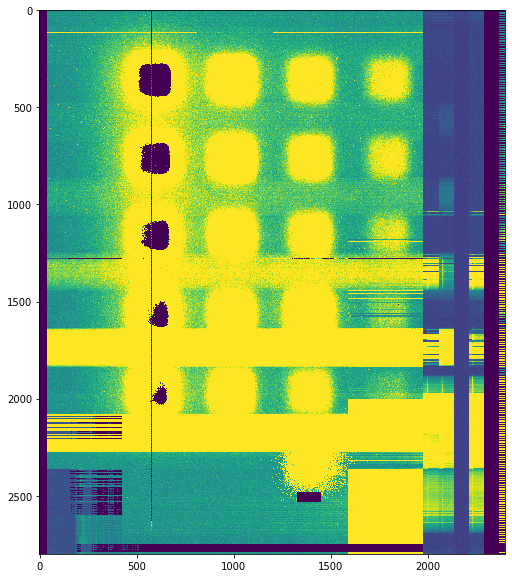

In [212]:
std[starty:endy,startx:endx]=0
plt.figure(figsize=(10,10))
plt.imshow(std,vmin=0,vmax=16)

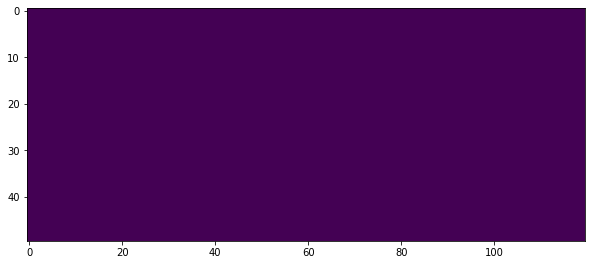

In [217]:
plt.figure(figsize=(10,10))
plt.imshow(std[starty:endy,startx:endx])

In [185]:
chosenPixels.shape

(600000,)

(100, 50, 120)


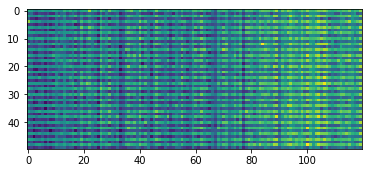

In [186]:
chosenPixels3d=chosenPixels.reshape((n_files,(endy-starty),(endx-startx)))
print(chosenPixels3d.shape)
plt.imshow(chosenPixels3d[0,:,:])

In [187]:
def bad_pix_qual(startx_fn,endx_fn,starty_fn,endy_fn,chosenPixels3d_fn):
    means_array_fn=np.zeros([endy_fn-starty_fn,endx_fn-startx_fn],dtype='float')
    stds_array_fn=np.zeros([endy_fn-starty_fn,endx_fn-startx_fn],dtype='float')
    heights_array_fn=np.zeros([endy_fn-starty_fn,endx_fn-startx_fn],dtype='float')
    
    bad_fits_counter=0
    means_fn=np.array([])
    stds_fn=np.array([])
    heights_fn=np.array([])
    x_vals_fn=np.array([])
    y_vals_fn=np.array([])

    for pix_y in range(0,(endy_fn-starty_fn)): #(endy-starty)*(endx-startx)
        for pix_x in range(0,(endx_fn-startx_fn)): #(endy-starty)*(endx-startx)
            badfit=False

            if (pix_x%30==0 and pix_y%30==0):
                print(pix_x,pix_y)
            histValues=plt.hist(chosenPixels3d_fn[:,pix_y,pix_x],bins=45)
            mphist=midpoints(histValues[1])
            # meanh=chosenPixels3d_fn[:,pix_y,pix_x].mean()
            meanh=mphist[histValues[0].argmax()]

            stdh=chosenPixels3d_fn[:,pix_y,pix_x].std()
            try:
                popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,stdh])
            except:
                bad_fits_counter+=1
                popt=[-1,-1,-1]
                badfit=True



            heights_array_fn[pix_y,pix_x]=popt[0]
            means_array_fn[pix_y,pix_x]=popt[1]
            stds_array_fn[pix_y,pix_x]=popt[2]
#             if((pix_x==47) and (pix_y==32)):
#                 plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
#                 plt.show()
            plt.cla()
            plt.clf()
#             print(pix_x,pix_y,popt)
            # if badfit=False:        
            x_vals_fn=np.append(x_vals_fn,pix_x)
            y_vals_fn=np.append(y_vals_fn,pix_y)
            heights_fn=np.append(heights_fn,popt[0])
            means_fn=np.append(means_fn,popt[1])
            stds_fn=np.append(stds_fn,popt[2])

    print("badfits",bad_fits_counter)


    return heights_fn, means_fn, stds_fn, x_vals_fn, y_vals_fn, means_array_fn, stds_array_fn, heights_array_fn

heights, means, stds, x_vals, y_vals, means_array, stds_array, heights_array = bad_pix_qual(startx,endx,starty,endy,chosenPixels3d)

0 0
30 0
60 0
90 0
0 30
30 30
60 30
90 30
badfits 0


<Figure size 432x288 with 0 Axes>

even heights
[1.45056137e+04 3.84007917e+01 9.22556861e+00] 70.61643200977501 65.88747719943916
odd heights
[6599.22169772   58.86594818   12.93081175] 81.72986455399466 60.08597337469621
even means
[19504.26445681  3090.67025462   122.24369502] 3092.833971962804 117.55852906155795
odd means
[18284.49280841  2712.85982131   113.73608551] 2721.6597882640845 110.08915645183893
even stds
[390.07636494   9.34750975   1.17344018] 9.410338354881521 1.2558562650165728
odd stds
[385.53442338   9.27690654   1.13599781] 9.288990486499623 1.2183222180403657


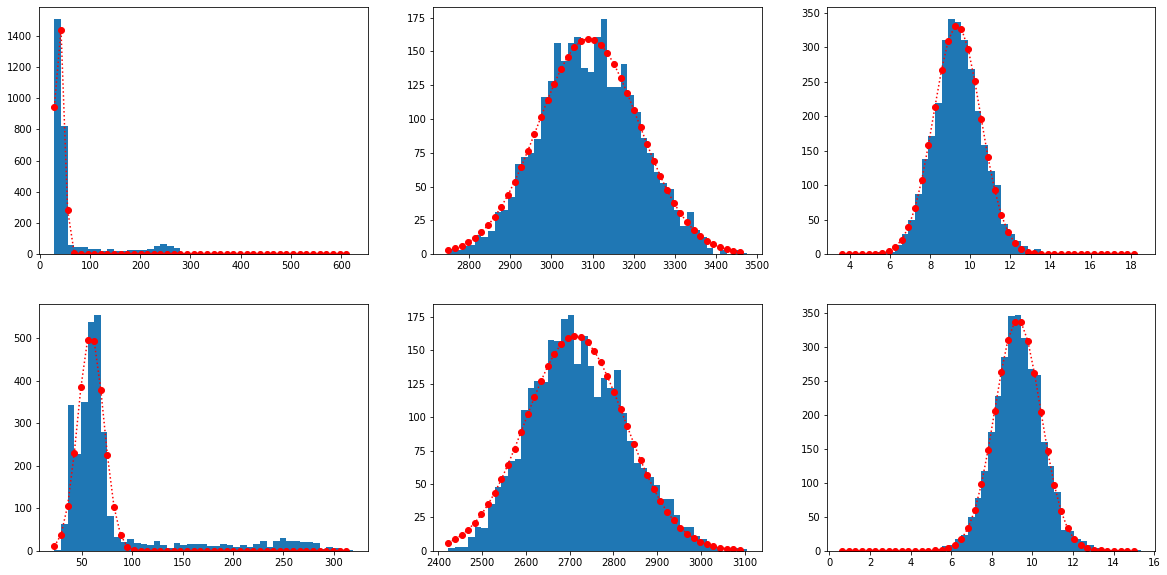

In [188]:
fig,ax=plt.subplots(2,3,figsize=(20,10))
df=pd.DataFrame({'x_vals':x_vals, 'y_vals': y_vals, 'heights':heights, 'means':means, 'stds':stds})

even_heights_mean,even_heights_std=return_param_BPM("even","heights",0)
odd_heights_mean,odd_heights_std=return_param_BPM("odd","heights",0)
even_means_mean,even_means_std=return_param_BPM("even","means",1)
odd_means_mean,odd_means_std=return_param_BPM("odd","means",1)
even_stds_mean,even_stds_std=return_param_BPM("even","stds",2)
odd_stds_mean,odd_stds_std=return_param_BPM("odd","stds",2)

In [189]:
eo_heights_means=np.zeros([endy-starty,endx-startx],dtype='float')
eo_means_means=np.zeros([endy-starty,endx-startx],dtype='float')
eo_stds_means=np.zeros([endy-starty,endx-startx],dtype='float')
eo_heights_stds=np.zeros([endy-starty,endx-startx],dtype='float')
eo_means_stds=np.zeros([endy-starty,endx-startx],dtype='float')
eo_stds_stds=np.zeros([endy-starty,endx-startx],dtype='float')

eo_heights_means[::2,:]=even_heights_mean
eo_heights_means[1::2,:]=odd_heights_mean
eo_means_means[::2,:]=even_means_mean
eo_means_means[1::2,:]=odd_means_mean
eo_stds_means[::2,:]=even_stds_mean
eo_stds_means[1::2,:]=odd_stds_mean
eo_heights_stds[::2,:]=even_heights_std
eo_heights_stds[1::2,:]=odd_heights_std
eo_means_stds[::2,:]=even_means_std
eo_means_stds[1::2,:]=odd_means_std
eo_stds_stds[::2,:]=even_stds_std
eo_stds_stds[1::2,:]=odd_stds_std

In [190]:
badpixmask=np.ones([endy-starty,endx-startx])
badpixmask[(means_array>(eo_means_means+5*eo_means_stds))]=-1
badpixmask[(stds_array>eo_stds_means+5*eo_stds_stds)]=-1
# badpixmask[(heights_array>eo_heights_means+6*eo_heights_stds)]=-1
badpixmask[(means_array<eo_means_means-5*eo_means_stds)]=-1
badpixmask[(stds_array<eo_stds_means-5*eo_stds_stds)]=-1
# means_array2[(heights_array<eo_heights_means-6*eo_heights_stds)]=-1

#ie.if mean=-1 it's a "bad pixel"

In [191]:
np.argwhere(stds_array>eo_stds_means+8*eo_stds_stds)


array([], shape=(0, 2), dtype=int64)

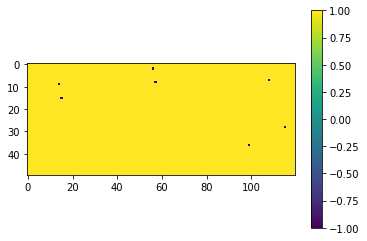

In [192]:
plt.imshow(badpixmask)
plt.colorbar()

3205.55 2612.596663886169 8.339222327307331
2 27.0 3200.3888888888887
[ 268.65288238 3202.32079393   10.04668393] smaller range
[ 266.31014801 3202.28430926    9.89698259]


Text(0, 0.5, 'ADC')

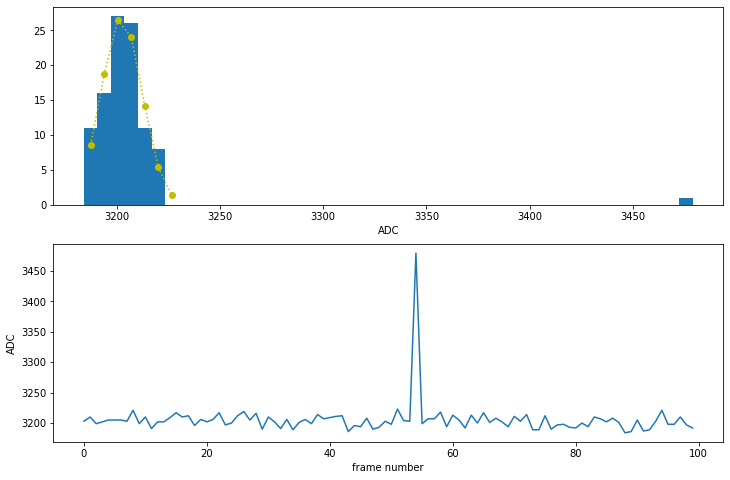

In [219]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
print(chosenPixels3d[:,6,86].mean(),means_array[5,21],stds_array[5,21])
histValues=ax[0].hist(chosenPixels3d[:,6,86],bins=45)
ax[0].set_xlabel("ADC")
mphist=midpoints(histValues[1])
print(histValues[0].argmax(),histValues[0].max(),mphist[histValues[0].argmax()])
# meanh=chosenPixels3d[:,6,86].mean()
meanh=mphist[histValues[0].argmax()]
stdh=chosenPixels3d[:,6,86].std()
popt,pcov=curve_fit(gaus,mphist[:histValues[0].argmax()+4],histValues[0][:histValues[0].argmax()+4],p0=[15,meanh,stdh])
popt2,pcov2=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,stdh])
print(popt,'smaller range')
print(popt2)
_=ax[0].plot(mphist[:histValues[0].argmax()+5],gaus(mphist[:histValues[0].argmax()+5],*popt2),'yo:',label='fit')
_=ax[1].plot(chosenPixels3d[:,6,86])
ax[1].set_xlabel("frame number")

ax[1].set_ylabel("ADC")


In [308]:
reshaped_CP=np.ones([endy-starty,endx-startx])
reshaped_CP=(chosenPixels3d-means_array)/stds_array
# np.tile(badpixmask,2)
# reshaped_CP[badpixmask>0]
badpixmask3d=np.tile(badpixmask,(n_files,1))
badpixmask3d=badpixmask3d.reshape(n_files,endy-starty,endx-startx)
reshaped_CP_BPM=reshaped_CP[badpixmask3d>0]
reshaped_CP_BPM.shape

(599300,)

0.3299683220775105 2612.596663886169 8.339222327307331
2 27.0 -0.19151497480741553
[2.71448729e+01 3.68716644e-03 1.01512200e+00] smaller range
[ 2.69082535e+01 -6.34930833e-07  1.00000252e+00]


Text(0, 0.5, 'ADC')

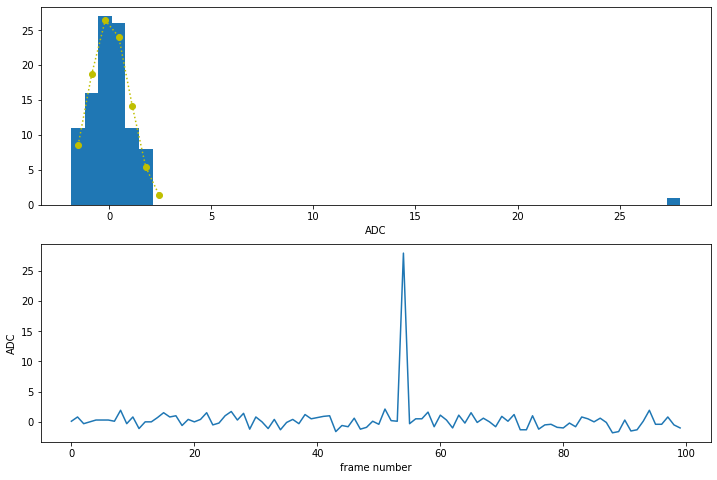

In [220]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
print(reshaped_CP[:,6,86].mean(),means_array[5,21],stds_array[5,21])
histValues=ax[0].hist(reshaped_CP[:,6,86],bins=45)
ax[0].set_xlabel("ADC")
mphist=midpoints(histValues[1])
print(histValues[0].argmax(),histValues[0].max(),mphist[histValues[0].argmax()])
# meanh=reshaped_CP[:,6,86].mean()
meanh=mphist[histValues[0].argmax()]
stdh=reshaped_CP[:,6,86].std()
popt,pcov=curve_fit(gaus,mphist[:histValues[0].argmax()+4],histValues[0][:histValues[0].argmax()+4],p0=[15,meanh,stdh])
popt2,pcov2=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,stdh])
print(popt,'smaller range')
print(popt2)
_=ax[0].plot(mphist[:histValues[0].argmax()+5],gaus(mphist[:histValues[0].argmax()+5],*popt2),'yo:',label='fit')
_=ax[1].plot(reshaped_CP[:,6,86])
ax[1].set_xlabel("frame number")

ax[1].set_ylabel("ADC")


In [195]:
print(np.argwhere(reshaped_CP<-7))
print(means_array[6,5],stds_array[6,5])

[[  0   9  14]
 [  3   9  14]
 [  4   9  14]
 [ 10   9  14]
 [ 12   9  14]
 [ 17   9  14]
 [ 18   9  14]
 [ 31   9  14]
 [ 32   9  14]
 [ 41   9  14]
 [ 44   9  14]
 [ 45   9  14]
 [ 47   9  14]
 [ 49   9  14]
 [ 51   9  14]
 [ 56  15  15]
 [ 59   9  14]
 [ 60   9  14]
 [ 70   9  14]
 [ 73   9  14]
 [ 74   9  14]
 [ 77   9  14]
 [ 79   9  14]
 [ 83  49  31]
 [ 83  49  84]
 [ 83  49  91]
 [ 83  49 118]
 [ 84  47  11]
 [ 84  47  23]
 [ 84  47  34]
 [ 84  47  44]
 [ 84  47  48]
 [ 84  47  49]
 [ 84  47  53]
 [ 84  47  62]
 [ 84  47  75]
 [ 84  47  90]
 [ 84  47  91]
 [ 84  47  97]
 [ 84  47 117]
 [ 85   9  14]
 [ 85  45  20]
 [ 85  45  29]
 [ 85  45  54]
 [ 85  45  65]
 [ 85  45  68]
 [ 85  45  76]
 [ 85  45  83]
 [ 85  45  93]
 [ 85  45 105]
 [ 85  45 106]
 [ 85  45 107]
 [ 85  45 110]
 [ 85  45 113]
 [ 86   9  14]
 [ 86  43  35]
 [ 86  43  38]
 [ 86  43  46]
 [ 86  43  75]
 [ 86  43 103]
 [ 86  43 117]
 [ 86  43 118]
 [ 87   9  14]
 [ 87  41   2]
 [ 87  41  19]
 [ 87  41  21]
 [ 87  41 

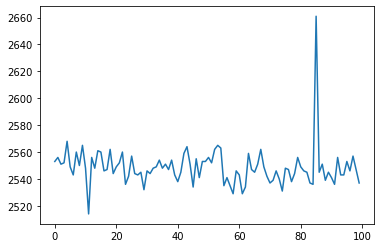

In [196]:
plt.plot(chosenPixels3d[:,11,41])

2930.6 9.432391001225511
[  47.00605007 2933.83715197    8.66348496]


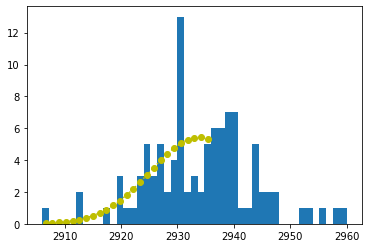

In [197]:
histValues=plt.hist(chosenPixels3d[:,6,5],bins=45)
mphist=midpoints(histValues[1])
# meanh=chosenPixels3d[:,6,5].mean()
meanh=mphist[histValues[0].argmax()]
stdh=chosenPixels3d[:,6,5].std()
print(meanh,stdh)
# popt,pcov=curve_fit(gaus,mphist[:histValues[0].argmax()+4],histValues[0][:histValues[0].argmax()+4],p0=[15,meanh,stdh])
popt2,pcov2=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,stdh])
# print(popt,'smaller range')
print(popt2)
_=plt.plot(mphist[:histValues[0].argmax()+5],gaus(mphist[:histValues[0].argmax()+5],*popt2),'yo:',label='fit')
# _=ax[1].plot(chosenPixels3d[:,6,5])

0.026781407793808026 2612.596663886169 8.339222327307331 1.0
[ 7.91063274e+00 -2.67796266e-05  1.00000407e+00]


Text(0.5, 0, 'SNR')

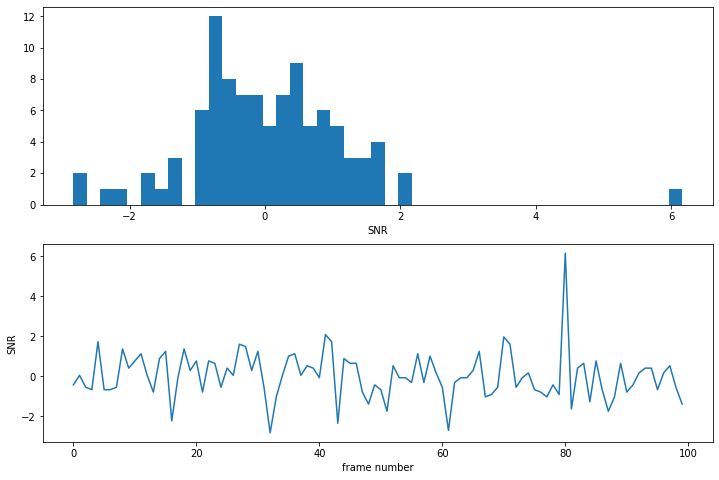

In [221]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
print(reshaped_CP[:,5,21].mean(),means_array[5,21],stds_array[5,21],badpixmask3d[0,5,21])
histValues=ax[0].hist(reshaped_CP[:,5,21],bins=45)
mphist=midpoints(histValues[1])
# meanh=reshaped_CP[:,5,21].mean()
meanh=mphist[histValues[0].argmax()]

stdh=reshaped_CP[:,5,21].std()
popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,stdh])
print(popt)
_=ax[1].plot(reshaped_CP[:,5,21].ravel())
ax[1].set_xlabel("frame number")

ax[1].set_ylabel("SNR")
ax[0].set_xlabel("SNR")

Text(0.5, 0, 'SNR')

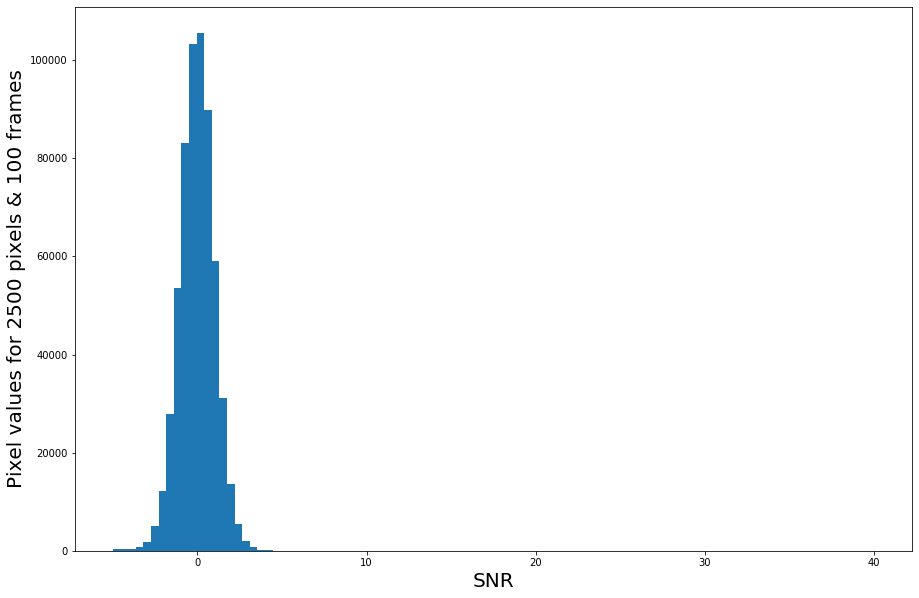

In [222]:
plt.subplots(1,1,figsize=(15,10))
_=plt.hist(reshaped_CP_BPM,bins=100,range=(-5,40))

plt.ylabel("Pixel values for 2500 pixels & 100 frames",fontsize=20)
plt.xlabel("SNR",fontsize=20)

Text(0.5, 0, 'SNR')

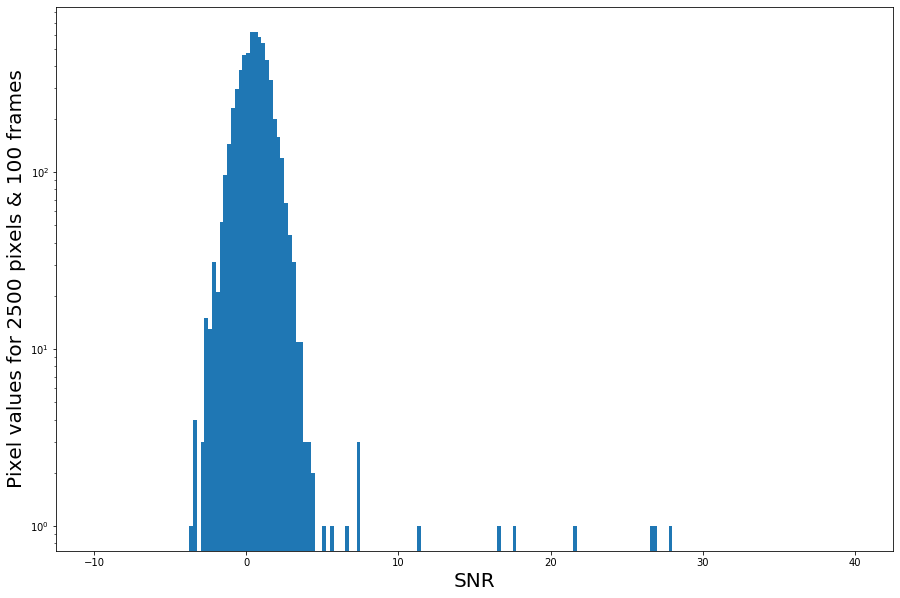

In [251]:

fig,ax=plt.subplots(1,1,figsize=(15,10))
ax.set_yscale('log')
# ax.set_ylim([100,200000])

all_hist=ax.hist(reshaped_CP[12,:,:].ravel(),bins=200,range=(-10,40))
ax.set_ylabel("Pixel values for 2500 pixels & 100 frames",fontsize=20)
ax.set_xlabel("SNR",fontsize=20)

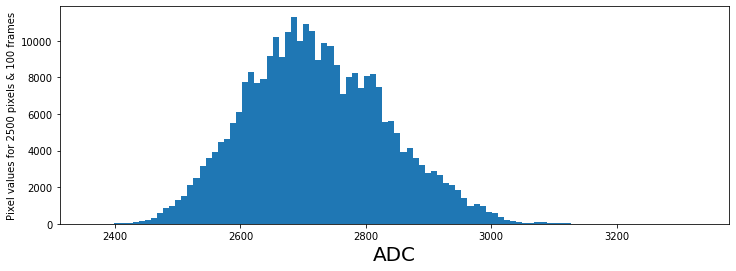

In [201]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.set_yscale('linear')
# ax.set_ylim([10,100000])
# ax.set_xlim([2600,3750])
ax.set_ylabel("Pixel values for 2500 pixels & 100 frames",fontsize=10)
ax.set_xlabel("ADC",fontsize=20)

all_hist=ax.hist(chosenPixels3d[:,1::2,:].ravel(),bins=100)

(41,) (41,)
[ 5.90968445e+04 -9.34996754e-03  9.84950278e-01]
[98.6178912  23.88433187  7.10988471]


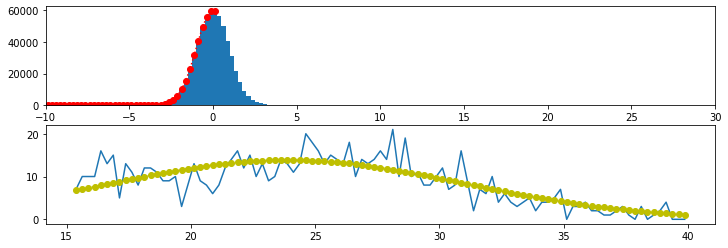

In [202]:
fig,ax=plt.subplots(2,1,figsize=(12,4))
all_hist=ax[0].hist(reshaped_CP_BPM,bins=200,range=(-10,40))

# ax.set_ylim(0,320000)
ax[0].set_xlim(-10,30)
mphist=midpoints(all_hist[1])
print(mphist[:41].shape,all_hist[0][:41].shape)
popt,pcov=curve_fit(gaus,mphist[:41],all_hist[0][:41],p0=[100000,0,1])
_=ax[0].plot(mphist[:41],gaus(mphist[:41],*popt),'ro:',label='fit')
print(popt)

popt2,pcov2=curve_fit(gaus,mphist[101:],all_hist[0][101:],p0=[60,25,1])
print(popt2) 

ax[1].plot(mphist[101:],all_hist[0][101:])
_=ax[1].plot(mphist[101:],gaus(mphist[101:],*popt2),'yo:',label='fit')

[167.71369162  23.71596034   7.29104734]


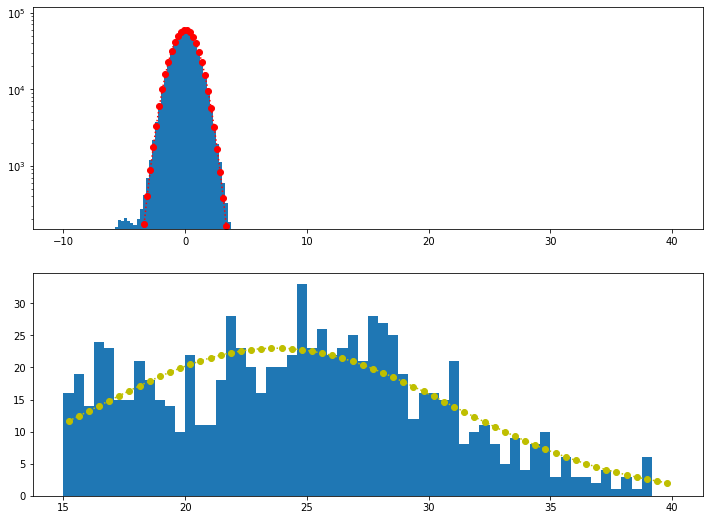

In [203]:
fig,ax=plt.subplots(2,1,figsize=(12,9))
ax[0].set_yscale('log')
ax[0].set_ylim([150.0,120000])
# ax[0].set_xlim([-5,10])

all_hist=ax[0].hist(reshaped_CP_BPM,bins=200,range=(-10,40))
mphist=midpoints(all_hist[1])
_=ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
# _=ax[0].plot(mphist[80:],gaus(mphist[80:],*popt2),'yo:',label='fit')


sub_hist=ax[1].hist(reshaped_CP_BPM,bins=60,range=(15,40))
sub_mphist=midpoints(sub_hist[1])
# _=ax[1].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
# _=ax[1].plot(mphist[20:],gaus(mphist[20:],*popt2),'yo:',label='fit')
popt3,pcov3=curve_fit(gaus,sub_mphist,sub_hist[0],p0=[60,25,1])
print(popt3) 
_=ax[1].plot(sub_mphist,gaus(sub_mphist,*popt3),'yo:',label='fit')

3305.0


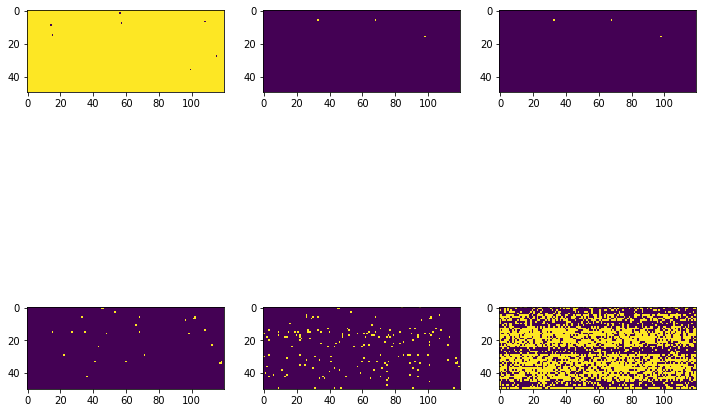

In [225]:
fig3,ax3=plt.subplots(2,3,figsize=(12,10))
sig10arr=(reshaped_CP[12,:,:]>20)
sig10arr=sig10arr.reshape(endy-starty,endx-startx)
sig5arr=(reshaped_CP[12,:,:]>10)
sig5arr=sig5arr.reshape(endy-starty,endx-startx)
sig4arr=(reshaped_CP[12,:,:]>4)
sig4arr=sig4arr.reshape(endy-starty,endx-startx)
sig3arr=(reshaped_CP[12,:,:]>3)
sig3arr=sig3arr.reshape(endy-starty,endx-startx)
sig2arr=(reshaped_CP[12,:,:]>2)
sig2arr=sig2arr.reshape(endy-starty,endx-startx)
sig1arr=(reshaped_CP[12,:,:]>0)
sig1arr=sig1arr.reshape(endy-starty,endx-startx)
ax3[0,0].imshow(badpixmask)
ax3[0,1].imshow(sig10arr)
sig10arr[badpixmask==0]=0
ax3[0,2].imshow(sig10arr)
# ax3[0,0].imshow(sig10arr-badpixmask)
# ax3[0,1].imshow(sig5arr)
# ax3[0,2].imshow(sig4arr)
ax3[1,0].imshow(sig3arr)
ax3[1,1].imshow(sig2arr)
ax3[1,2].imshow(sig1arr)
print(((reshaped_CP[2,:,:]>0)*1.0).sum())

with open('zerodam_allframes_0deg.npy', 'wb') as f:
    np.save(f, reshaped_CP)
    
    
    
    

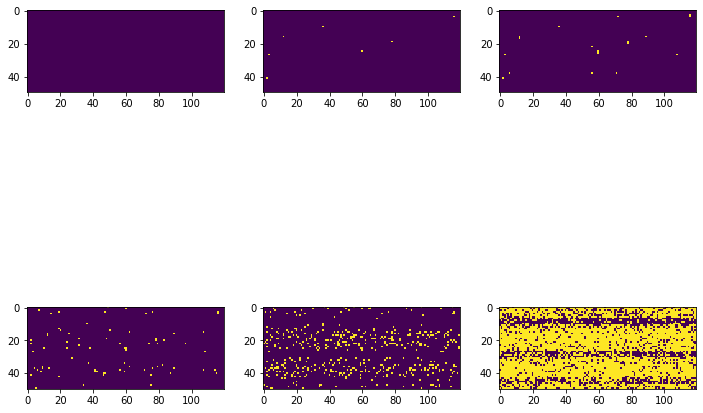

In [226]:
fig3,ax3=plt.subplots(2,3,figsize=(12,10))
sig10arr=(reshaped_CP[12,:,:]>500)
sig10arr=sig10arr.reshape(endy-starty,endx-startx)
sig5arr=(reshaped_CP[12,:,:]>10)
sig5arr=sig5arr.reshape(endy-starty,endx-startx)
sig4arr=(reshaped_CP[12,:,:]>4)
sig4arr=sig4arr.reshape(endy-starty,endx-startx)
sig3arr=(reshaped_CP[12,:,:]>3)
sig3arr=sig3arr.reshape(endy-starty,endx-startx)
sig2arr=(reshaped_CP[12,:,:]>2)
sig2arr=sig2arr.reshape(endy-starty,endx-startx)
sig1arr=(reshaped_CP[12,:,:]>0)
sig1arr=sig1arr.reshape(endy-starty,endx-startx)
ax3[0,0].imshow(sig10arr)
ax3[0,1].imshow(sig5arr)
ax3[0,2].imshow(sig4arr)
ax3[1,0].imshow(sig3arr)
ax3[1,1].imshow(sig2arr)
ax3[1,2].imshow(sig1arr)
# print(((reshaped_CP[2,:,:]>0)*1.0).sum()/9999.0)

30


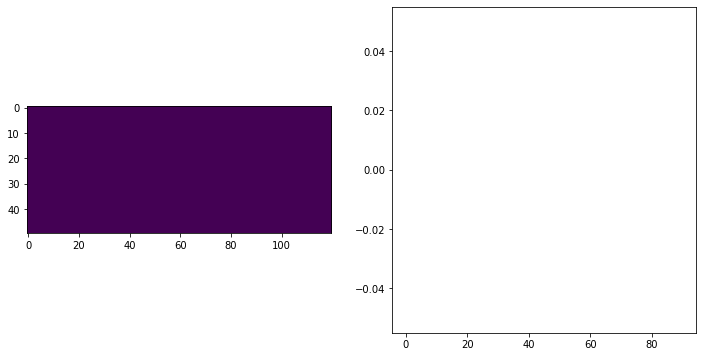

29


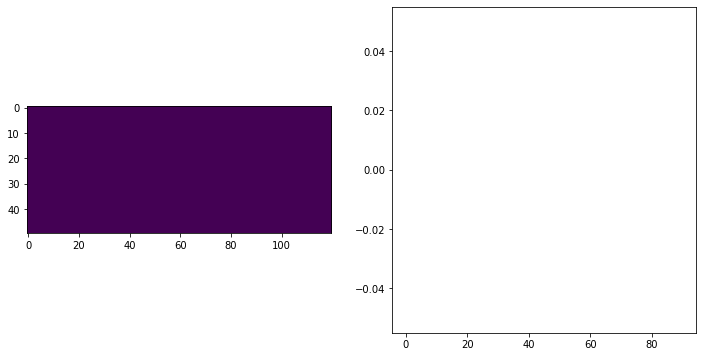

28


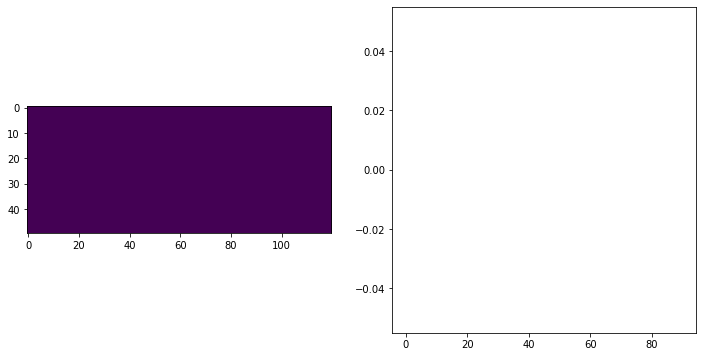

27


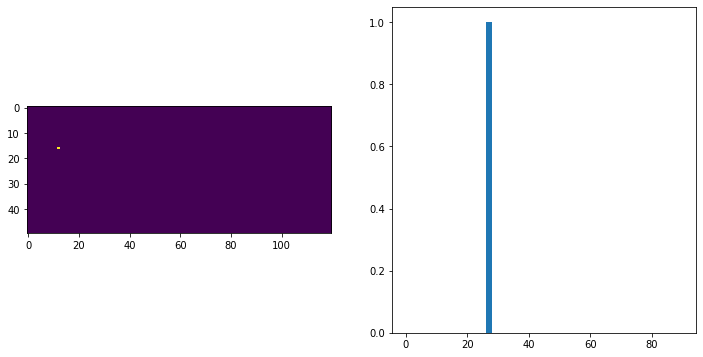

26


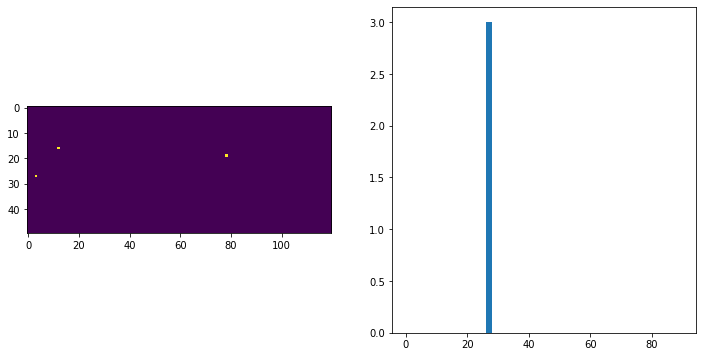

25


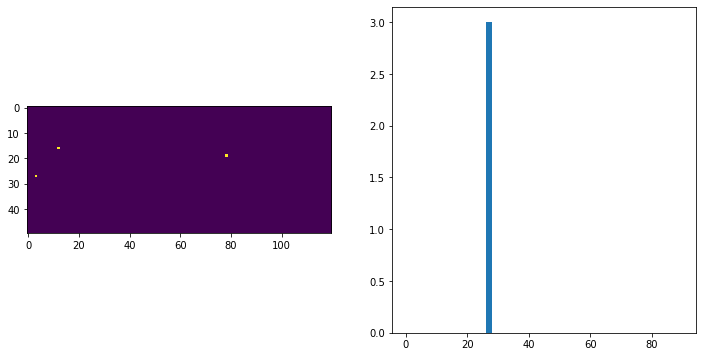

24


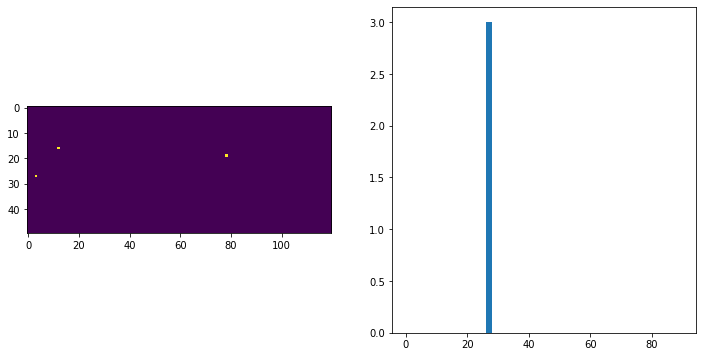

23


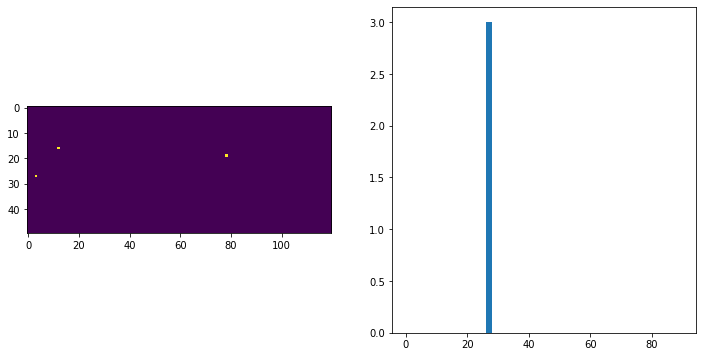

22


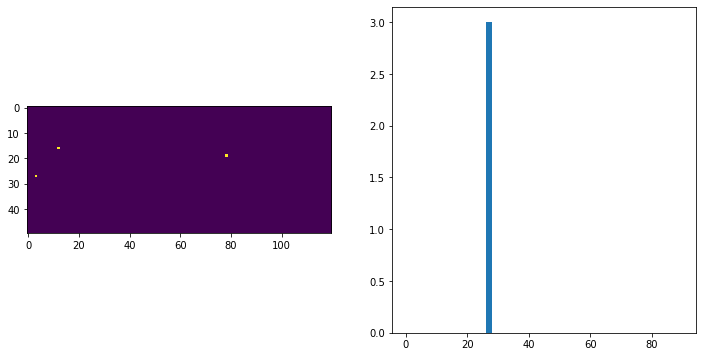

21


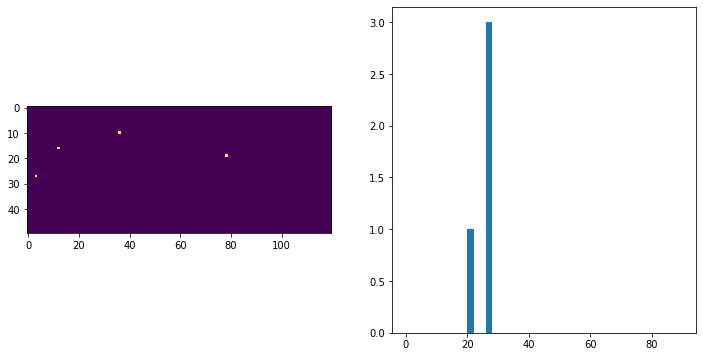

20


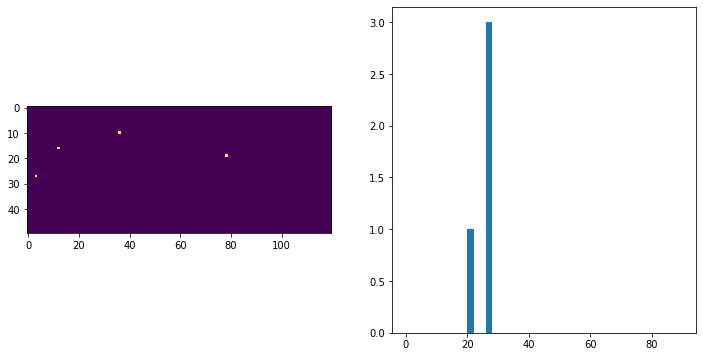

19


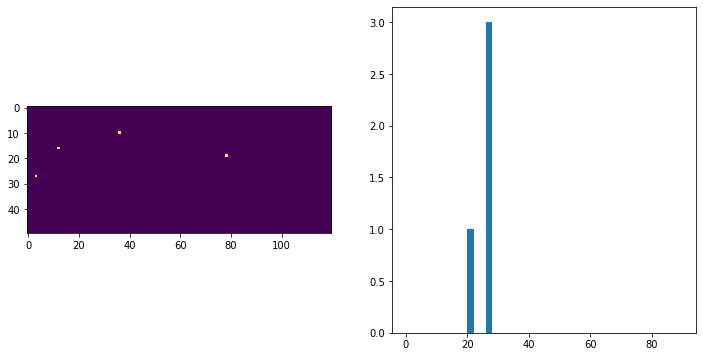

18


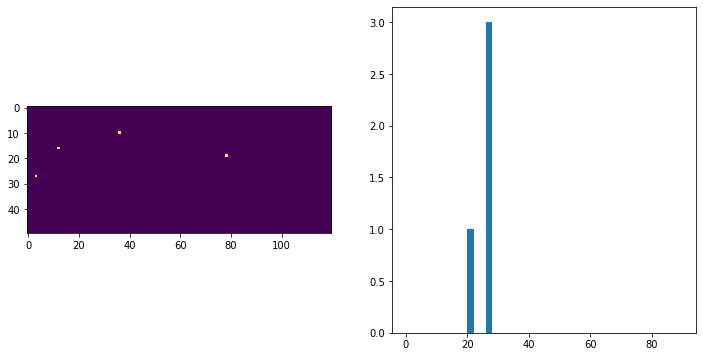

17


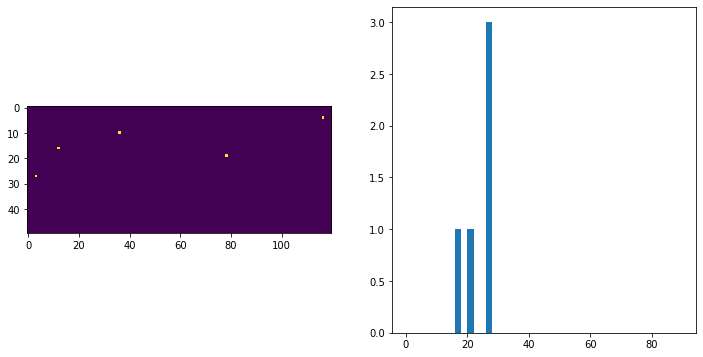

16


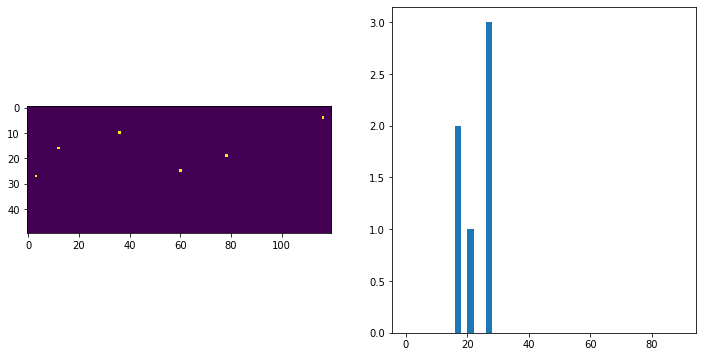

15


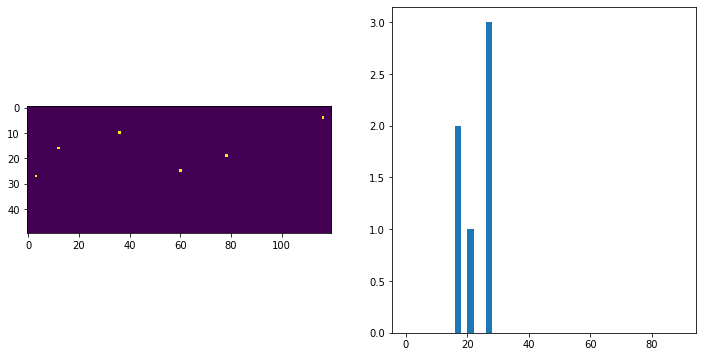

14


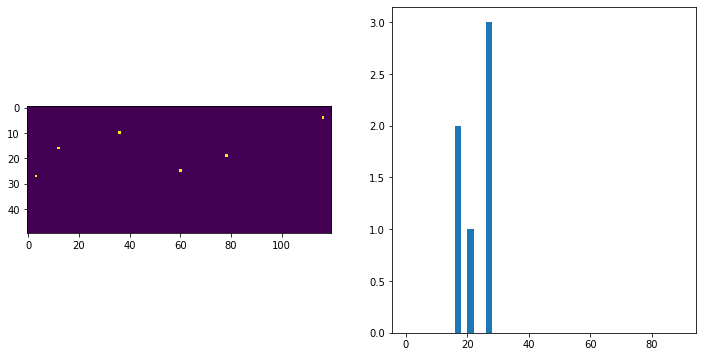

13


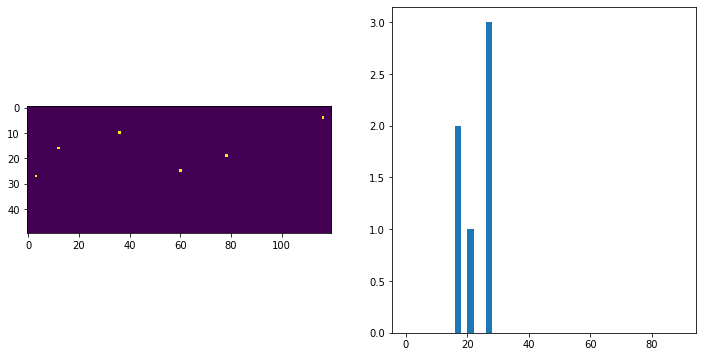

12


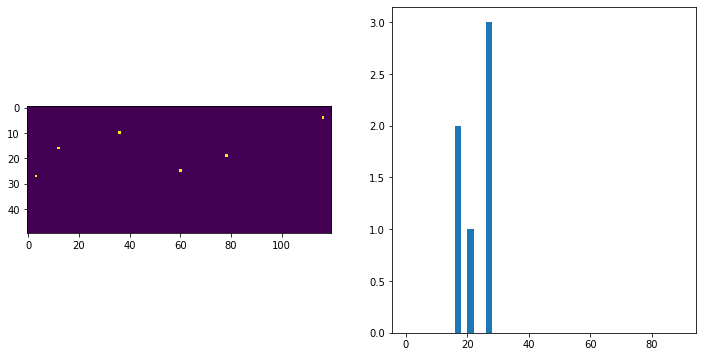

11


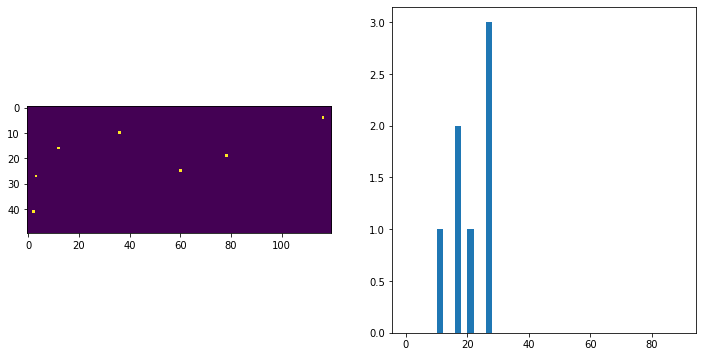

10


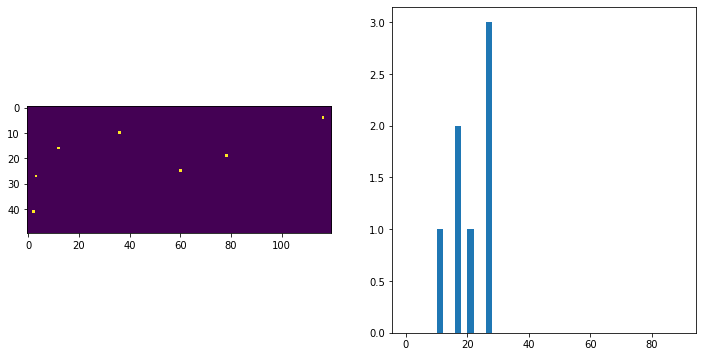

9


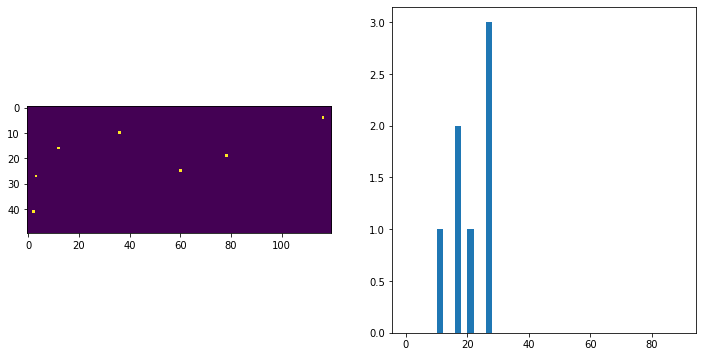

8


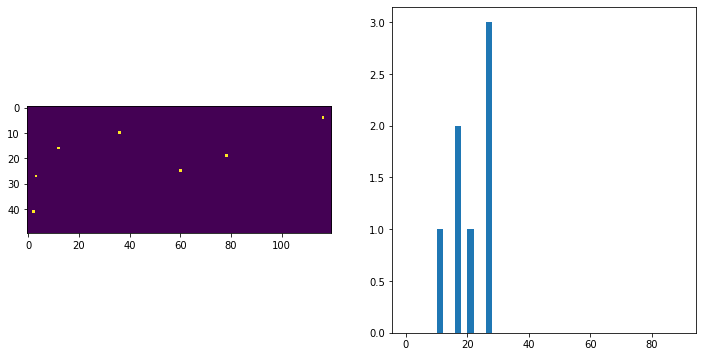

7


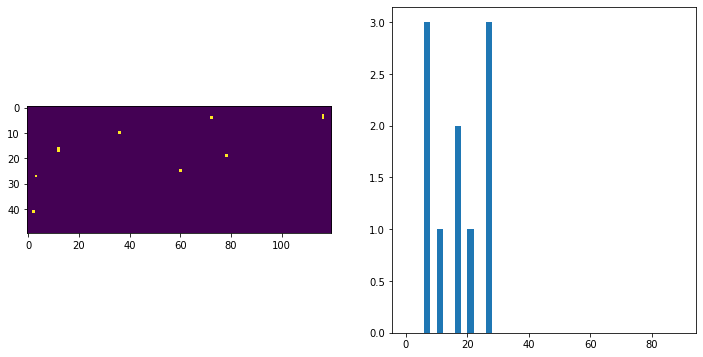

6


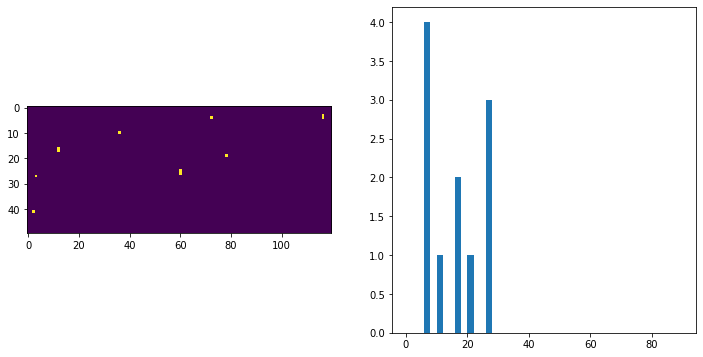

5


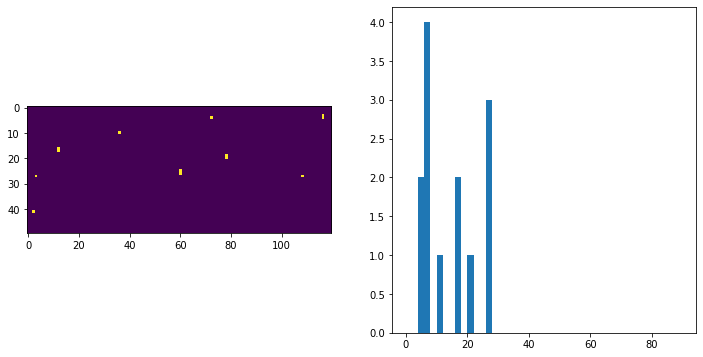

4


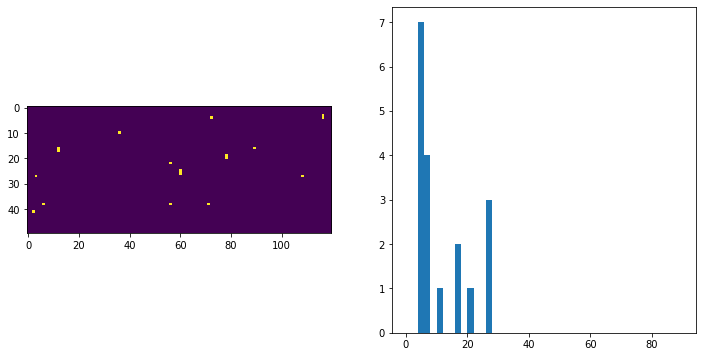

3


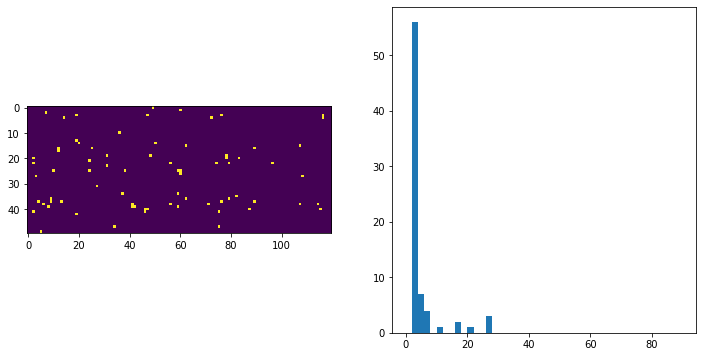

In [227]:
for i in np.arange (30,2,-1):
    sigarr=(reshaped_CP[12,:,:]>i)
    sigarr=sigarr.reshape(endy-starty,endx-startx)
    print (i)
    fig,ax=plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(sigarr)
    ax[1].hist(reshaped_CP[12,:,:][sigarr>0.1],range=(0,90),bins=45)
    plt.pause(0.2)


# plt.subplots(1,1,figsize=(10,10))

# seed=np.ones([endy-starty,endx-startx])
# # seed[reshaped_CP[12,:,:]>28]=1
# seed1=(reshaped_CP[12,:,:]>21)*1.0
# seed2=(reshaped_CP[12,:,:]>28)*1.0
# seed3=(reshaped_CP[12,:,:]>17)*1.0
# seed3=(reshaped_CP[12,:,:]>10)*1.0
# seed1=seed1+seed2+seed3
# plt.imshow(reshaped_CP[12,:,:],vmin=4,vmax=27)
# plt.colorbar()
# plt.pause(0.1)

(50, 120) (50, 120)
convolved [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[-2.2756303  -1.99993944 -0.42225097 ... -0.00310659 -1.21447935
  -0.27240925]
 [ 0.54343127  1.19900213  0.44231291 ... -1.17021018 -0.24780482
   1.35788417]
 [-0.10986977 -0.93459431 -1.26737033 ... -0.54400869 -0.19655525
  -0.14573806]
 ...
 [ 1.4168849   0.22571306  0.11162263 ...  2.52729952  1.69259259
   1.34784411]
 [-0.46204197 -0.70722675 -0.31732161 ...  1.31175995  1.50632856
   0.46668093]
 [-0.08825884  0.67006084  0.16769832 ... -0.73679874 -0.22242112
  -0.69364239]]
above3 [15.61074252  3.35715858  3.05860589  8.37884252 25.66984312  3.18524349
 12.90056284 14.03970658 31.10302653  3.40466718  3.04411359  3.12243442
  3.32815904  3.71873277  4.1368259  27.62277298 18.42593533 14.72237557
  3.21658945 27.28167656  3.42856053  4.83153274 12.614361    4.86989253
  7.44156464 36.1504730

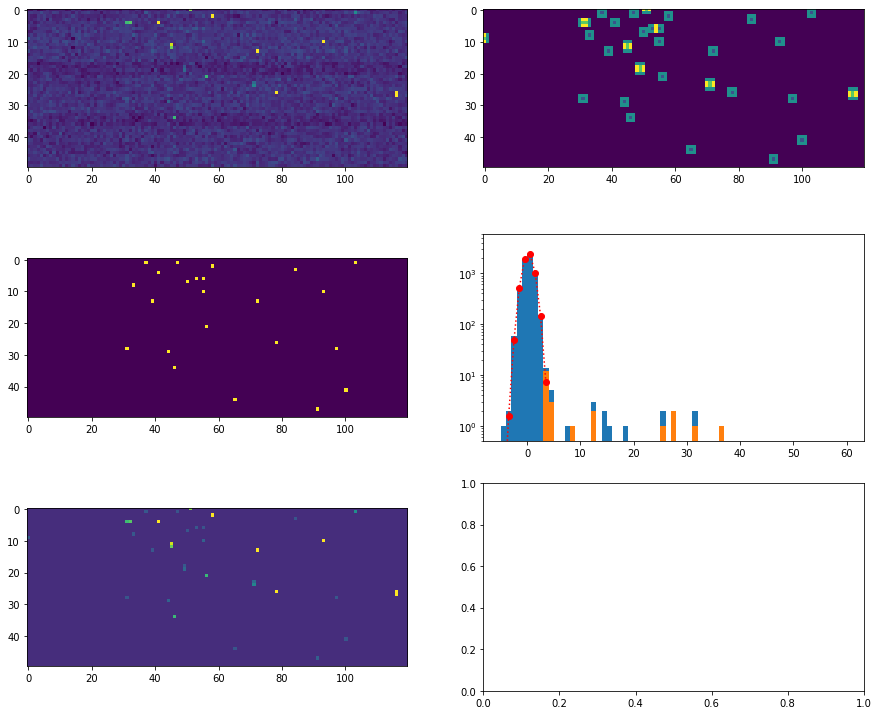

[ 3.35715858  3.05860589  8.37884252 25.66984312  3.18524349 31.10302653
  3.40466718  3.04411359  3.12243442  3.32815904  4.1368259  27.62277298
  3.21658945 27.28167656 12.614361   36.15047304  3.16319724  3.29068357
  4.43029432 12.6933242   3.14282944  3.17678702  4.02287698]


In [324]:
fig,ax=plt.subplots(3,2,figsize=(15,13))

kern=np.ones([3,3])
kern=kern*2
kern[1,1]=1

seed=(reshaped_CP[17,:,:]>3)*1.0
subseed=seed[1:-1,1:-1]
seed_loc=np.argwhere(subseed>0.5)+[1,1]
with open('seed_loc_40rad_dam_neg20.npy','wb')as f:
    np.save(f,seed_loc)
# print(seed_loc+[1,1])
convolved = ndimage.convolve(seed, kern)
newarr=(convolved==1)*1.0
print(convolved.shape,newarr.shape)
# for seedling in seed_loc:
#     print(seedling,convolved[seedling[0]+1,seedling[1]+1])
# print(seed.shape,subseed.shape,np.argwhere(subseed>0.5))
print('convolved',convolved)
ax[0,0].imshow(reshaped_CP[17,:,:],vmin=-3,vmax=20)
ax[0,1].imshow(convolved)
ax[1,0].imshow(newarr)
above3=np.copy(reshaped_CP[17,:,:])
above3[above3<3]=0
print(reshaped_CP[17,:,:])
print('above3',above3[above3>0.1],np.argwhere(above3>1))
ax[2,0].imshow(above3,vmin=-3,vmax=20)
ax[1,1].set_yscale('log')
all_hist=ax[1,1].hist(reshaped_CP[17,:,:].ravel(),range=(-5,60),bins=65)
ax[1,1].hist(reshaped_CP[17,:,:][convolved==1].ravel(),range=(-5,60),bins=65)
mphist=midpoints(all_hist[1])
ax[1,1].set_ylim(0.5,6000)
# ax[1,1].set_xlim(-5,10)

popt2,pcov2=curve_fit(gaus,mphist[:6],all_hist[0][:6],p0=[60,0,1])
print(popt2) 
_=ax[1,1].plot(mphist[:9],gaus(mphist[:9],*popt2),'ro:',label='fit')
# print(convolved[convolved==1])
# plt.hist(reshaped_CP[17,:,:][convolved==1])
# plt.colorbar()
plt.pause(0.1)
print(reshaped_CP[17,:,:][convolved==1])

(array([5862.,    0.,   10.,    0.,    0.,  104.,    0.,    8.,    0.,
          16.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

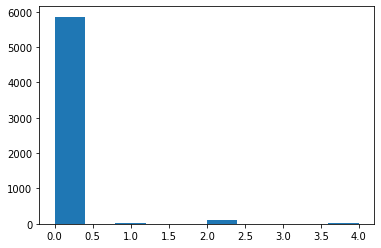

In [256]:
plt.hist(convolved.ravel())

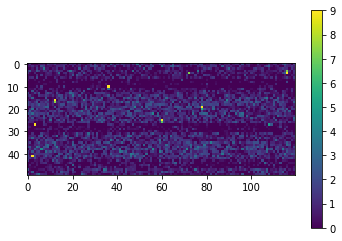

In [229]:
plt.imshow(reshaped_CP[12,:,:],vmin=0,vmax=9)
plt.colorbar()

In [230]:
## fig3,ax3=plt.subplots(2,4,figsize=(17,10))
sig9arr=(reshaped_CP[20,:,:]>20)
sig9arr=sig9arr.reshape(endy-starty,endx-startx)
sig10arr=(reshaped_CP[1,:,:]>20)
sig10arr=sig10arr.reshape(endy-starty,endx-startx)
sig5arr=(reshaped_CP[2,:,:]>20)
sig5arr=sig5arr.reshape(endy-starty,endx-startx)
sig4arr=(reshaped_CP[3,:,:]>20)
sig4arr=sig4arr.reshape(endy-starty,endx-startx)
sig3arr=(reshaped_CP[4,:,:]>20)
sig3arr=sig3arr.reshape(endy-starty,endx-startx)
sig2arr=(reshaped_CP[5,:,:]>20)
sig2arr=sig2arr.reshape(endy-starty,endx-startx)
sig1arr=(reshaped_CP[10,:,:]>20)
sig1arr=sig1arr.reshape(endy-starty,endx-startx)
sig7arr=(reshaped_CP[11,:,:]>20)
sig7arr=sig7arr.reshape(endy-starty,endx-startx)
ax3[0,0].imshow(sig10arr)
ax3[0,1].imshow(sig5arr)
ax3[0,2].imshow(sig4arr)
ax3[0,3].imshow(sig9arr)
ax3[1,0].imshow(sig3arr)
ax3[1,1].imshow(sig2arr)
ax3[1,2].imshow(sig1arr)
ax3[1,3].imshow(sig7arr)

IndexError: index 3 is out of bounds for axis 1 with size 3

In [ ]:
reshaped_CP3d=(chosenPixels3d-reshaped_means)/reshaped_stds
fig,ax=plt.subplots(1,2,figsize=(12,5))
histValues=ax[0].hist(reshaped_CP3d[:,100,97],histtype='step',bins=45)
ax[0].set_xlim(-5,10)
mphist=midpoints(histValues[1])
ax[1].hist(chosenPixels3d[:,100,97],color='r',histtype='step',bins=45)
popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[10,0,1])
ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
print(popt)


In [ ]:
#remove bad values

all_CP_data=np.array([])
bad_fits_counter=0
outside_range_counter=0


for pix_x in range(0,(endx-startx)): #(endy-starty)*(endx-startx)
    for pix_y in range(0,(endy-starty)): #(endy-starty)*(endx-startx)
        if (pix_x%10==0 and pix_y%10==0):
            print(pix_x,pix_y)
        histValues=plt.hist(chosenPixels3d[:,pix_y,pix_x],bins=45)
        # meanh=chosenPixels3d[:,pix_y,pix_x].mean()
        meanh=mphist[histValues[0].argmax()]

        mphist=midpoints(histValues[1])
        try:
            popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,15])
        except:
            bad_fits_counter+=1
            continue


        plt.cla()
        plt.clf()
        
        if (pix_y%2==0):
            if(popt[1]>even_means_mean+(3*even_means_std) or popt[1]<even_means_mean-(3*even_means_std)):
                outside_range_counter+=1
#                 print(popt,even_means_mean,even_means_std)
                continue
            elif(popt[0]>even_heights_mean+(3*even_heights_std) or popt[0]<even_heights_mean-(3*even_heights_std)):
                outside_range_counter+=1
#                 print('height',popt,even_heights_mean,even_heights_std)
                continue
            elif(popt[2]>even_stds_mean+(3*even_stds_std) or popt[2]<even_stds_mean-(3*even_stds_std)):
                outside_range_counter+=1
#                 print(popt)
                continue
        if (pix_y%2==1):
            if(popt[1]>odd_means_mean+(3*odd_means_std) or popt[1]<odd_means_mean-(3*odd_means_std)):
                outside_range_counter+=1
#                 print(popt)
                continue
            elif(popt[0]>odd_heights_mean+(3*odd_heights_std) or popt[0]<odd_heights_mean-(3*odd_heights_std)):
                outside_range_counter+=1
                continue
#                 print(popt)
            elif(popt[2]>odd_stds_mean+(3*odd_stds_std) or popt[2]<odd_stds_mean-(3*odd_stds_std)):
                outside_range_counter+=1
#                 print(popt)
                continue

        reshaped_CP=(chosenPixels3d[:,pix_y,pix_x]-popt[1])/popt[2]
        all_CP_data=np.append(all_CP_data,reshaped_CP)

print("BF",bad_fits_counter,"OR",outside_range_counter)


In [ ]:
df

In [ ]:
df[(df['y_vals']%2==0)]

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(9,4))
_=ax[0].hist(df['heights'],bins=100,range=(0,1000))
_=ax[1].hist(df['means'],bins=100)
_=ax[2].hist(df['stds'],bins=100)

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(20,10))
_=ax[0,0].hist(df[(df['y_vals']%2==0)&(df['heights']<1000)]['heights'],bins=100)
_=ax[0,1].hist(df[(df['y_vals']%2==0)&(df['heights']<1000)]['means'],bins=100,range=(2500,4200))
_=ax[0,2].hist(df[(df['y_vals']%2==0)&(df['heights']<1000)]['stds'],bins=100)
_=ax[1,0].hist(df[(df['y_vals']%2==1)&(df['heights']<1000)]['heights'],color='r',bins=100)
_=ax[1,1].hist(df[(df['y_vals']%2==1)&(df['heights']<1000)]['means'],color='r',bins=100,range=(2500,4200))
_=ax[1,2].hist(df[(df['y_vals']%2==1)&(df['heights']<1000)]['stds'],color='r',bins=100)

In [ ]:
even_means_mean=df[(df['y_vals']%2==0)&(df['heights']<1000)]['means'].mean()
odd_means_mean=df[(df['y_vals']%2==1)&(df['heights']<1000)]['means'].mean()
even_means_std=df[(df['y_vals']%2==0)&(df['heights']<1000)]['means'].std()
odd_means_std=df[(df['y_vals']%2==1)&(df['heights']<1000)]['means'].std()
even_heights_mean=df[(df['y_vals']%2==0)&(df['heights']<1000)]['heights'].mean()
odd_heights_mean=df[(df['y_vals']%2==1)&(df['heights']<1000)]['heights'].mean()
even_heights_std=df[(df['y_vals']%2==0)&(df['heights']<1000)]['heights'].std()
odd_heights_std=df[(df['y_vals']%2==1)&(df['heights']<1000)]['heights'].std()
even_stds_mean=df[(df['y_vals']%2==0)&(df['heights']<1000)]['stds'].mean()
odd_stds_mean=df[(df['y_vals']%2==1)&(df['heights']<1000)]['stds'].mean()
even_stds_std=df[(df['y_vals']%2==0)&(df['heights']<1000)]['stds'].std()
odd_stds_std=df[(df['y_vals']%2==1)&(df['heights']<1000)]['stds'].std()
print(even_means_mean,odd_means_mean)
print(even_means_std,odd_means_std)
print(even_heights_mean,odd_heights_mean)
print(even_heights_std,odd_heights_std)
print(even_stds_mean,odd_stds_mean)
print(even_stds_std,odd_stds_std)


In [ ]:
# chosenPixels=chosenPixels.reshape((n_files,(endy-starty)*(endx-startx)))
# chosenPixels.shape
df

In [ ]:
print(means)
means2=means.reshape((endy-starty),(endx-startx))
stds2=stds.reshape((endy-starty),(endx-startx))
fig,ax=plt.subplots(2,1)
chosenPixels3d2=(chosenPixels3d-means2)/stds2
histValues=ax[0].hist(chosenPixels3d2[:,100,97],bins=45)
mphist=midpoints(histValues[1])
popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,0,1])
_=ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
print(popt)
# data_mean=popt[1]
# data_std=popt[2]
# reshaped_CP=(chosenPix-data_mean)/data_std

# dtr=ax[1].hist(reshaped_CP,bins=45)
# print(chosenPixels3d[:,0,0])
# print(chosenPixels3d[:,0,0].mean())
# print(chosenPix)
chosenPixels3d2[:,100,97]>4

In [ ]:
all_CP_data=np.array([])
fig,ax=plt.subplots(2,1)

histValues=ax[0].hist(chosenPix,bins=45)
histValues[1][:-1].shape
mphist=midpoints(histValues[1])
popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,3300,15])
_=ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')

data_mean=popt[1]
data_std=popt[2]
reshaped_CP=(chosenPix-data_mean)/data_std

dtr=ax[1].hist(reshaped_CP,bins=45)

In [ ]:
popt

In [ ]:
#replace bad values
all_CP_data=np.array([])
bad_fits_counter=0
outside_range_counter=0


for pix_x in range(0,(endx-startx)): #(endy-starty)*(endx-startx)
    for pix_y in range(0,(endy-starty)): #(endy-starty)*(endx-startx)
        if (pix_x%10==0 and pix_y%10==0):
            print(pix_x,pix_y)
        histValues=plt.hist(chosenPixels3d[:,pix_y,pix_x],bins=45)
        meanh=chosenPixels3d[:,pix_y,pix_x].mean()
        mphist=midpoints(histValues[1])
        try:
            popt,pcov=curve_fit(gaus,mphist,histValues[0],p0=[15,meanh,15])
        except:
            bad_fits_counter+=1
            continue


        plt.cla()
        plt.clf()
        
        if (pix_y%2==0):
            if(popt[1]>even_means_mean+(3*even_means_std) or popt[1]<even_means_mean-(3*even_means_std)):
                outside_range_counter+=1
#                 print(popt,even_means_mean,even_means_std)
                popt[1]=-999
                popt[2]=-999
            elif(popt[0]>even_heights_mean+(3*even_heights_std) or popt[0]<even_heights_mean-(3*even_heights_std)):
                outside_range_counter+=1
#                 print('height',popt,even_heights_mean,even_heights_std)
                popt[1]=-999
                popt[2]=-999
            elif(popt[2]>even_stds_mean+(3*even_stds_std) or popt[2]<even_stds_mean-(2*even_stds_std)):
                outside_range_counter+=1
#                 print(popt)
                popt[1]=-999
                popt[2]=-999
        if (pix_y%2==1):
            if(popt[1]>odd_means_mean+(3*odd_means_std) or popt[1]<odd_means_mean-(3*odd_means_std)):
                outside_range_counter+=1
#                 print(popt)
                popt[1]=-999
                popt[2]=-999
            elif(popt[0]>odd_heights_mean+(3*odd_heights_std) or popt[0]<odd_heights_mean-(3*odd_heights_std)):
                popt[1]=-999
                popt[2]=-999
                outside_range_counter+=1
#                 print(popt)
            elif(popt[2]>odd_stds_mean+(3*odd_stds_std) or popt[2]<odd_stds_mean-(3*odd_stds_std)):
                outside_range_counter+=1
#                 print(popt)
                popt[1]=-999
                popt[2]=-999

        reshaped_CP=(chosenPixels3d[:,pix_y,pix_x]-popt[1])/popt[2]
        all_CP_data=np.append(all_CP_data,reshaped_CP)

print("BF",bad_fits_counter,"OR",outside_range_counter)

In [ ]:
plt.imshow(reshaped_CP3d[1,:,:],vmin=0,vmax=10)
plt.colorbar()

In [ ]:
plt.imshow(reshaped_CP3d[2,:,:],vmin=0,vmax=10)
plt.colorbar()

In [ ]:
plt.imshow(reshaped_CP3d[3,:,:],vmin=0,vmax=10)
plt.colorbar()

In [ ]:
#ART
plt.subplots(1,1,figsize=(10,8))
sig4arr=(reshaped_CP3d[0,:,:]>4)
plt.plot(reshaped_CP3d[0,:,:])
print(sig4arr)
sig4arr=sig4arr.reshape(endy-starty,endx-startx)
plt.imshow(sig4arr)

In [ ]:
fig4,ax4=plt.subplots(1,2,figsize=(10,5))
ax4[0].plot(reshaped_CP3d[:,10,10])
histValues=ax4[1].hist(reshaped_CP3d[:,10,10],bins=45)
popt,pcov=curve_fit(gaus,histValues[1][:-1],histValues[0],p0=[10,0,1])
ax[1].plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
print(popt)


In [ ]:
all_CP_data

fig,ax=plt.subplots(2,1,figsize=(12,4))

all_hist=ax[0].hist(all_CP_data,bins=500,range=(-5,35))
# ax.set_ylim(0,320000)
ax[0].set_xlim(-5,30)
mphist=midpoints(all_hist[1])
popt,pcov=curve_fit(gaus,mphist,all_hist[0],p0=[100000,0,1])
_=ax[0].plot(mphist,gaus(mphist,*popt),'ro:',label='fit')

popt2,pcov2=curve_fit(gaus,mphist[250:],all_hist[0][250:],p0=[60,25,1])
print(popt2) 

ax[1].plot(mphist[250:],all_hist[0][250:])
_=ax[1].plot(mphist[250:],gaus(mphist[250:],*popt2),'yo:',label='fit')


fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.set_yscale('log')
ax.set_ylim([200.0,30000])

all_hist=ax.hist(all_CP_data,bins=500,range=(-5,35))
mphist=midpoints(all_hist[1])
_=ax.plot(mphist,gaus(mphist,*popt),'ro:',label='fit')
_=ax.plot(mphist[250:],gaus(mphist[250:],*popt2),'yo:',label='fit')

In [ ]:
all_CP_data[all_CP_data>4].shape

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
ax.set_yscale('log')
ax.set_ylim([0.1,10000])

all_hist=ax.hist(all_CP_data,bins=150)
# _=ax.plot(all_hist[1][:-1],gaus(all_hist[1][:-1],*popt),'ro:',label='fit')

In [ ]:
all_CP_data=np.array([])
bad_fits_counter=0
for pix in range((endy-starty)*(endx-startx)):
# if pix%200==0:
    print(pix)
#     plt.plot(chosenPixels[:,pix])
#     plt.show()
#     plt.pause(1)
    plt.clf()

    histValues=plt.hist(chosenPixels[:,pix],bins=45)
    # meanh=chosenPixels[:,pix].mean()

    meanh=mphist[histValues[0].argmax()]
	try:
        popt,pcov=curve_fit(gaus,histValues[1][:-1],histValues[0],p0=[15,meanh,15])
    except:
        bad_fits_counter+=1
        continue
    print(popt)
    plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
    plt.show()
#     plt.cla()
    reshaped_CP=(chosenPixels[:,pix]-popt[1])/popt[2]
    all_CP_data=np.append(all_CP_data,reshaped_CP)
print(bad_fits_counter)

In [ ]:
all_CP_data=np.array([])
bad_fits_counter=0

for pix in range(0,10): #(endy-starty)*(endx-startx)
    if pix%200==0:
        print(pix)
#     plt.plot(chosenPixels[:,pix])
#     plt.show()
#     plt.pause(1)
#     histValues=plt.hist(chosenPixels[:,pix],bins=45)
#     meanh=chosenPixels[:,pix].mean()
    try:
        popt,pcov=curve_fit(gaus,histValues[1][:-1],histValues[0],p0=[15,meanh,15])
    except:
        bad_fits_counter+=1

        continue
#     print(popt)
#     plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
#     plt.show()
    plt.cla()
    plt.clf()
    reshaped_CP=(chosenPixels[:,pix]-popt[1])/popt[2]
    all_CP_data=np.append(all_CP_data,reshaped_CP)

print(bad_fits_counter)


In [ ]:
all_CP_data=np.array([])
bad_fits_counter=0

for pix in range(0,10): #(endy-starty)*(endx-startx)
    if pix%200==0:
        print(pix)
#     plt.plot(chosenPixels[:,pix])
#     plt.show()
#     plt.pause(1)
#     histValues=plt.hist(chosenPixels[:,pix],bins=45)
#     meanh=chosenPixels[:,pix].mean()
    histValues=plt.hist(chosenPixels[:,pix],bins=45)
    mu,sig=norm.fit((chosenPixels[:,pix]))
    print(mu,sig)
    plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],15, mu, sig),'ro:',label='fit')
    plt.show()
    plt.clf()


In [ ]:
all_CP_data=np.array([])
bad_fits_counter=0
for pix in range(348,351): #(endy-starty)*(endx-startx)
# if pix%200==0:
    print(pix)
#     plt.plot(chosenPixels[:,pix])
#     plt.show()
#     plt.pause(1)
    plt.clf()

    print(chosenPixels[:,pix].min()-1)
    print(chosenPixels[:,pix].max()+1)
    bins = np.linspace(chosenPixels[:,pix].min()-1,chosenPixels[:,pix].min()+45,45 )
    digitized = np.digitize(chosenPixels[:,pix], bins)
    print(bins)
    print(digitized)
    print(len(bin_means))
#     histValues=plt.hist(chosenPixels[:,pix],bins=45)
    
#     meanh=chosenPixels[:,pix].mean()
#     try:
#         popt,pcov=curve_fit(gaus,histValues[1][:-1],histValues[0],p0=[15,meanh,15])
#     except:
#         bad_fits_counter+=1
#         continue
#     print(popt)
#     plt.plot(histValues[1][:-1],gaus(histValues[1][:-1],*popt),'ro:',label='fit')
#     plt.show()
# #     plt.cla()
#     reshaped_CP=(chosenPixels[:,pix]-popt[1])/popt[2]
#     all_CP_data=np.append(all_CP_data,reshaped_CP)
# print(bad_fits_counter)


In [ ]:
np.linspace(chosenPixels[:,pix].min()-1,chosenPixels[:,pix].max()-1,45).shape

In [24]:
arrr=np.random.rand(5,5)
print(arrr,'\n\n',arrr[1::2,:])

[[0.26317239 0.93813709 0.47409645 0.55702643 0.79161294]
 [0.59689037 0.48684897 0.25682387 0.44204297 0.67585104]
 [0.36649008 0.16621356 0.05738193 0.62100128 0.71518509]
 [0.21525997 0.69791977 0.22101079 0.95403563 0.56247168]
 [0.92116944 0.57578942 0.38057115 0.21360604 0.28016015]] 

 [[0.59689037 0.48684897 0.25682387 0.44204297 0.67585104]
 [0.21525997 0.69791977 0.22101079 0.95403563 0.56247168]]


In [183]:
number of hits/size of clusters vs radiation damage 



SyntaxError: invalid syntax (<ipython-input-183-24f0af58bdc7>, line 1)

In [190]:
a1=np.ones((3,3))
a1[1,1]=7
b1=np.ones((3,3))
a1>5

array([[False, False, False],
       [False,  True, False],
       [False, False, False]])

In [297]:
c1=np.array([[1,2,3],[4,5,6],[7,8,9]])

In [298]:
c1

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [299]:
d1=np.copy(c1)

In [300]:
d1[c1<3]=0

In [301]:
d1

array([[0, 0, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [302]:
c1

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])